In this real-world example we are going to use Historic data from the Solcast API to perform quality assurance on some measurement data of GTI - Global Tilted Irradiance, also known as POA (Plane Of Array Irradiance).

The measurements data used in the exercise is a re-worked time-series sourced from the Goodwin Creek, Mississippi SURFRAD site.

We will be using some external libraries for this task, in particular [Pvanalytics](https://pvanalytics.readthedocs.io/en/stable/), an industry standard when it comes to PV analytics, and [Plotly](https://plotly.com/python/), a common Python plotting library.

In [1]:
# ! pip install plotly pvanalytics

In [2]:
import numpy as np
import pandas as pd

import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

from pvanalytics import quality

from solcast import historic

# leave commented out to get interactive html plots
# import plotly.io
# plotly.io.renderers.default = "png"

## Fetch Data

Here we have we have 15 minute measurements, labelled with period_end, at UTC-5.

If you need to align the timezone and period of your measurement data, check out `3.1 Comparing to Measurements: Timezone and Time Period alignment.ipynb`.

For this timeseries, the panel is oriented due east, with an tilt of 40 degrees from the horizontal

In [3]:
ARRAY_AZIMUTH = -90  # East, Solcast convention
ARRAY_TILT = 40
ARRAY_TYPE = "fixed"

In [4]:
measurements = pd.read_csv("./data/3.2b_sample_measurements.csv", index_col=0, parse_dates=True)
measurements.head()
measurements.tail()

,gti
period_end,
2021-06-22 23:00:00-05:00,0
2021-06-22 23:15:00-05:00,0
2021-06-22 23:30:00-05:00,0
2021-06-22 23:45:00-05:00,0
2021-06-23 00:00:00-05:00,0


In [5]:

# NOTE: this will consume an API request!
resp = historic.radiation_and_weather(
    latitude=34.2547,
    longitude=-89.8729,
    output_parameters=["gti", "clearsky_gti", "clearsky_ghi", "zenith"],
    start="2021-06-21 00:00:00-05:00",
    end="2021-06-23 00:00:00-05:00",
    period="PT15M",
    tilt=ARRAY_TILT,
    azimuth=ARRAY_AZIMUTH,
    array_type=ARRAY_TYPE,
)
solcast = resp.to_pandas()
# convert to UTC-7 to compare to measurements
solcast.index = solcast.index.tz_convert("-05:00:00")  

solcast.head()

,gti,clearsky_gti,clearsky_ghi,zenith
period_end,,,,
2021-06-21 00:15:00-05:00,0,0,0,121
2021-06-21 00:30:00-05:00,0,0,0,122
2021-06-21 00:45:00-05:00,0,0,0,122
2021-06-21 01:00:00-05:00,0,0,0,122
2021-06-21 01:15:00-05:00,0,0,0,122


In [6]:
df = solcast.add_suffix("_solcast").join(measurements.add_suffix("_meas"))
display(df.head())

,gti_solcast,clearsky_gti_solcast,clearsky_ghi_solcast,zenith_solcast,gti_meas
period_end,,,,,
2021-06-21 00:15:00-05:00,0,0,0,121,0.0
2021-06-21 00:30:00-05:00,0,0,0,122,0.0
2021-06-21 00:45:00-05:00,0,0,0,122,0.0
2021-06-21 01:00:00-05:00,0,0,0,122,0.0
2021-06-21 01:15:00-05:00,0,0,0,122,0.0


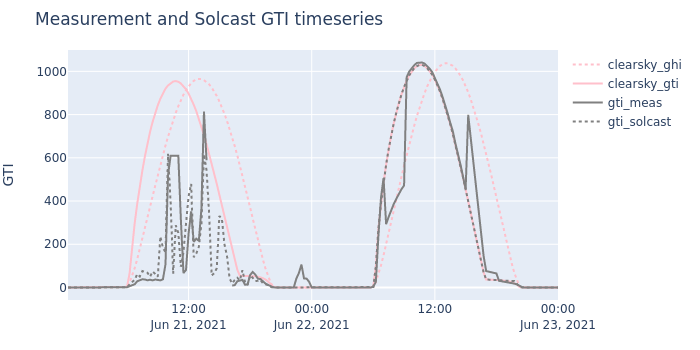

In [7]:
# Create figure with secondary y-axis
fig = make_subplots()

# Add traces
fig.add_trace(
    go.Scatter(x=df.index, y=df["clearsky_ghi_solcast"], name="clearsky_ghi", marker=dict(color="pink"), line=dict(dash="dot")),
)
fig.add_trace(
    go.Scatter(x=df.index, y=df["clearsky_gti_solcast"], name="clearsky_gti", marker=dict(color="pink")),
)
fig.add_trace(
    go.Scatter(x=df.index, y=df["gti_meas"], name="gti_meas", marker=dict(color="grey")),
)
fig.add_trace(
    go.Scatter(x=df.index, y=df["gti_solcast"], name="gti_solcast", marker=dict(color="grey"), line=dict(dash="dot")),
)


fig.update_layout(
    title_text="Measurement and Solcast GTI timeseries", autosize=False, width=700, height=350,
    margin=dict(t=50, b=50, l=50, r=50),
)
fig.update_yaxes(title_text="GTI", secondary_y=False)
fig.show()

## Missing and Stale data
A common issue with measurement data is to have an incomplete time series with missing or stale data. We can identify gaps and stale sequences in our data using pvanalytics [quality.gaps.stale_values_diff](https://pvanalytics.readthedocs.io/en/stable/generated/pvanalytics.quality.gaps.stale_values_diff.html). Once identified we can fill or replace their values with Solcast API"s Historial actuals.

In [8]:
missing = df["gti_meas"].isnull()
# only check sun-up periods for staleness (expecting zeros at nighttime!)
stale = quality.gaps.stale_values_diff(df["gti_meas"].where(df["zenith_solcast"] < 88), window=3, mark="all")
df["missing_or_stale"] =  missing | stale

# make a quality-controlled GTI
df["gti_QC"] = df["gti_meas"].mask(df["missing_or_stale"], df["gti_solcast"])

Let's plot the results. The dashed line represents where we filled missing measurement data with Solcast"s Historical data.

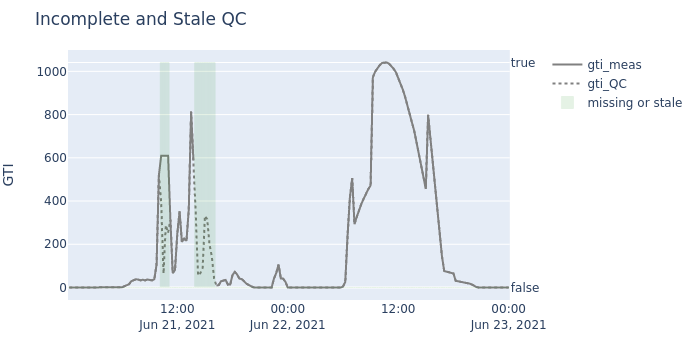

In [9]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.index, y=df["gti_meas"], name="gti_meas", marker=dict(color="grey")),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.index, y=df["gti_QC"], name="gti_QC", marker=dict(color="grey"), line=dict(dash="dot")),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(
        x=df.index, 
        y=df["missing_or_stale"], 
        name="missing or stale", 
        marker_line_width=1, 
        marker_color="green",
        marker_line_color="green",
        opacity=0.1
    ),
    secondary_y=True,
)

fig.update_layout(
    autosize=False, width=700, height=350, title="Incomplete and Stale QC",
    margin=dict(t=50, b=50, l=50, r=50),
)
fig.update_yaxes(title_text="GTI", secondary_y=False)
fig.show()

## Non-Physical Values
A common way to flag anomalous values is to check for values that exceed the clearsky values. We will use the [clearsky_limits](https://pvanalytics.readthedocs.io/en/stable/generated/pvanalytics.quality.irradiance.clearsky_limits.html#pvanalytics.quality.irradiance.clearsky_limits) function from `pvanalytics` with clearsky values from the Solcast API.

In [10]:
# check we do not exceed clearsky irradiance during the day 
df["non_physical"] = ~quality.irradiance.clearsky_limits(
    df["gti_QC"], df["clearsky_gti_solcast"], csi_max=1.2
) & (df["zenith_solcast"] <= 88)

# cloud enhancement can temporarily exceed clearsky limits (especially on a 5min scale)
# so check that there is at least two contiguous timesteps
df["non_physical"] = ( 
    (df["non_physical"] & df["non_physical"].shift(1))
    | (df["non_physical"] & df["non_physical"].shift(-1))
)

# night time
df["non_physical"] = df["non_physical"] | (
    (df["gti_meas"] > 0) & (df["clearsky_gti_solcast"] == 0) & (df["zenith_solcast"] > 93)
)

# replace non-physical data with Solcast GTI
df["gti_QC"] = df["gti_QC"].mask(df["non_physical"], other=df["gti_solcast"])

Let's plot the results to see where we have flagged values

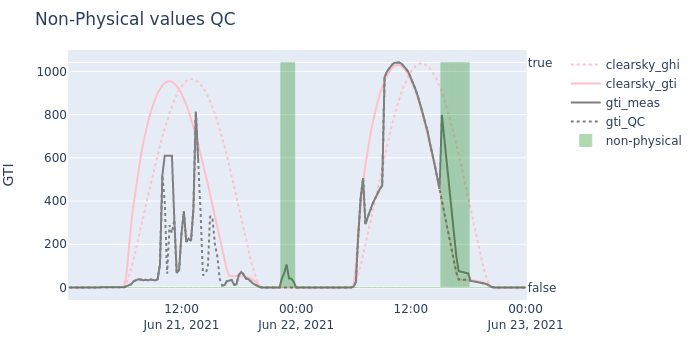

In [11]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.index, y=df["clearsky_ghi_solcast"], name="clearsky_ghi", marker=dict(color="pink"), line=dict(dash="dot")),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df.index, y=df["clearsky_gti_solcast"], name="clearsky_gti", marker=dict(color="pink")),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df.index, y=df["gti_meas"], name="gti_meas", marker=dict(color="grey")),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df.index, y=df["gti_QC"], name="gti_QC", marker=dict(color="grey"), line=dict(dash="dot")),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(
        x=df.index, 
        y=df["non_physical"], 
        name="non-physical", 
        marker_line_width=1, 
        opacity=0.3, 
        marker_color="green",
        marker_line_color="green"
    ),
    secondary_y=True,
)

fig.update_layout(
    title_text="Non-Physical values QC", autosize=False, width=700, height=350,
    margin=dict(t=50, b=50, l=50, r=50),
)
fig.update_yaxes(title_text="GTI", secondary_y=False)
fig.show()

## Manual Flagging

There are unlimited ways for measurement data to be wrong - and no automated check can get all of them. Some times, data needs to be manually flagged - or you may have flags coming from other systems that you want to apply.

In [12]:
# Here we have some corrupt measurement data, for example due to dodgy pyranometer averaging.
df["manual_bad_flag"] = False
df.loc[slice("2021-06-22 07:15", "2021-06-22 09:00"), "manual_bad_flag"] = True

# replace manually with Solcast GTI
df["gti_QC"] = df["gti_QC"].mask(df["manual_bad_flag"], other=df["gti_solcast"])

Plotting up the results:

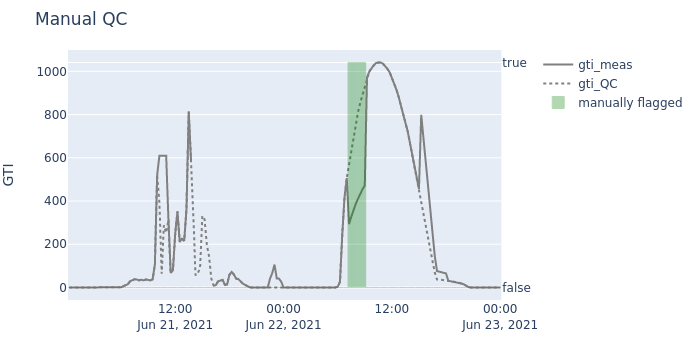

In [13]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.index, y=df["gti_meas"], name="gti_meas", marker=dict(color="grey")),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.index, y=df["gti_QC"], name="gti_QC", marker=dict(color="grey"), line=dict(dash="dot")),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(
        x=df.index, 
        y=df["manual_bad_flag"], 
        name="manually flagged", 
        marker_line_width=1, 
        opacity=0.3, 
        marker_color="green",
        marker_line_color="green"
    ),
    secondary_y=True,
)

fig.update_layout(
    title_text="Manual QC", autosize=False, width=700, height=350,
    margin=dict(t=50, b=50, l=50, r=50),
)
fig.update_yaxes(title_text="GTI", secondary_y=False)
fig.show()

## Overall Visualisation

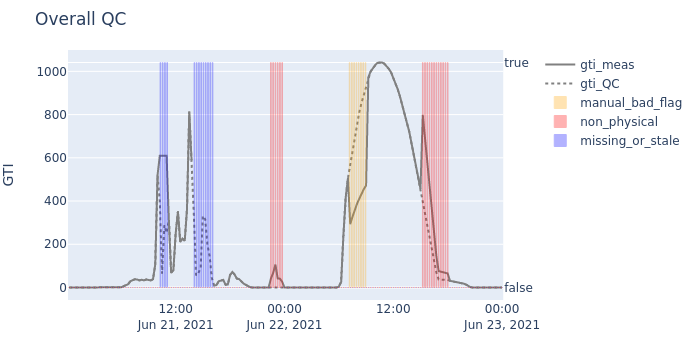

In [14]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.index, y=df["gti_meas"], name="gti_meas", marker=dict(color="grey")),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.index, y=df["gti_QC"], name="gti_QC", marker=dict(color="grey"), line=dict(dash="dot")),
    secondary_y=False,
)

for qc_col, color in [
    ("manual_bad_flag", "orange"),
    ("non_physical", "red"),
    ("missing_or_stale", "blue"),
]:
    fig.add_trace(
        go.Bar(
            x=df.index, 
            y=df[qc_col], 
            name=qc_col, 
            marker_line_width=1, 
            opacity=0.3, 
            marker_color=color,
            marker_line_color=color,
        ),
        secondary_y=True,
    )

fig.update_layout(
    title_text="Overall QC", autosize=False, width=700, height=350,
    margin=dict(t=50, b=50, l=50, r=50),
)
fig.update_yaxes(title_text="GTI", secondary_y=False)
fig.show()